In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [2]:
from core.utils.preprocessing import df_to_xy
#fix rnd seed
np.random.seed(7)

# Read and sanitize the data
# Read and sanitize the data
df = pd.read_csv("../data/t00/export/result__t00_prop.csv")
df_full = df.copy()
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code", "prop_time_spent"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()


x, y = df_to_xy(df, fuse_risk=False)
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5, random_state = 0)

**Loss function**

In [3]:
@np.vectorize
def sigmoid1024(x):
    base = 2048.0**2
    return (base**x/(base**x + 1))

@np.vectorize
def loss(x):
    offset = 1
    x1 = (x + offset) / 8.0
    x2 = (x) / 20.0
    return (1 - sigmoid1024(x1) *  np.cos(x2/np.pi))

def gain(x):
    return 1 - loss(x)

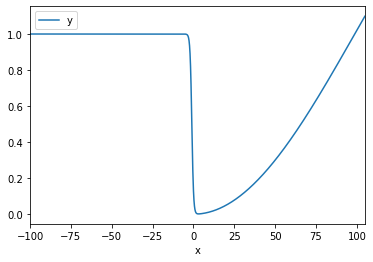

In [22]:
x = np.arange(-100, 105, 0.1)
y = loss(x)

out_df = pd.DataFrame({'x':x, 'y':y})
out_df.plot.line(x='x', y='y')

In [5]:
from core.utils.data_augmentation import DACombine

In [6]:
from core.models.deep import keras_hiddenless_model, keras_model, loss_tf, gain_tf, KerasModel
from keras import backend as K

Using TensorFlow backend.


**Metrics**

In [7]:
from core.models.metrics import gain_mean, avg_gain_ratio

**Model: No data Augmentation**

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


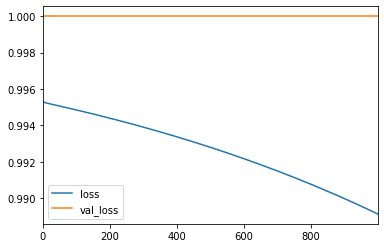

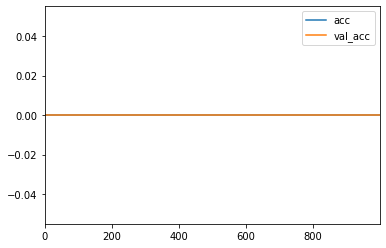

In [8]:
model = KerasModel(loss=loss_tf, metrics=[gain_tf], batch_size=256, epochs=1000, no_hidden_layer=True)
da = DACombine()
xTrain_a, yTrain_a = xTrain.astype(K.floatx()), yTrain.astype(K.floatx())
split = int(xTrain.shape[1] * 0.75)
#xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
#xTrain_a, yTrain_a = da.fit_predict(xTrain, yTrain, size=1024, distance=10)
history = model.fit(xTrain_a.astype(K.floatx()), yTrain_a.astype(K.floatx()),  validation_split=0.25, verbose=0)

#print(history.history)

loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  4.666666666666667
gain_ratio:  0.04666666666666667


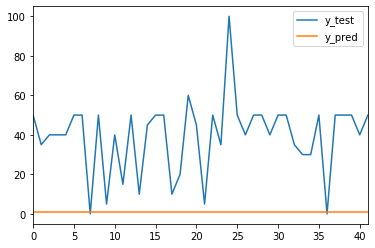

In [9]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

**Model with data augmentation**

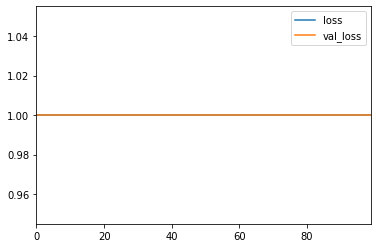

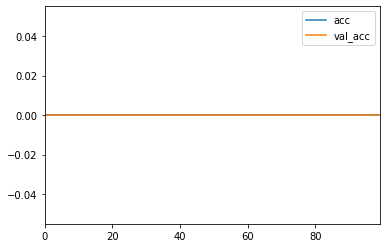

In [10]:
#sci-kit like training
model = KerasModel(loss=loss_tf, metrics=[gain_tf], batch_size=64, epochs=100)
da = DACombine()
xTrain_a, yTrain_a = xTrain, yTrain
split = int(xTrain.shape[1] * 0.75)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'),  validation_data=(xVal, yVal), verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  4.714285714285714
gain_ratio:  0.04714285714285714


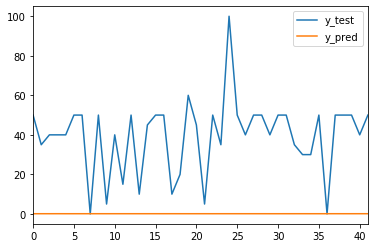

In [11]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

** Model using _mse_ loss and data augmentation**

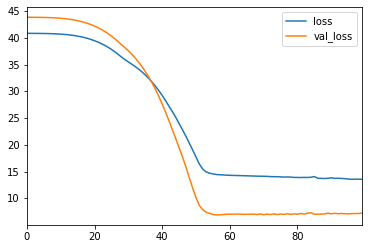

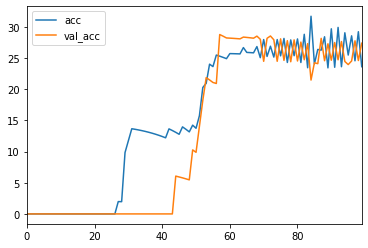

In [12]:
#sci-kit like training
model = KerasModel(loss='mae', metrics=[gain_tf], batch_size=128, epochs=100)
da = DACombine()
split = int(xTrain.shape[1] * 0.75)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
#xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'), validation_data=(xVal, yVal))
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  31.761904761904763
gain_ratio:  0.48638384274496616


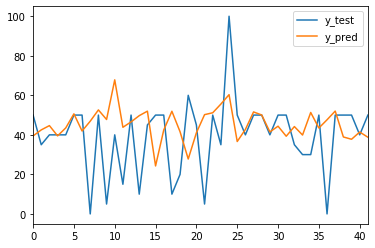

In [13]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

**CMP Model**

Train on 48 samples, validate on 13 samples
Epoch 1/200
48/48 [==============================] - 1s 12ms/step - loss: 0.9957 - gain_tf: 0.0000e+00 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 2/200
48/48 [==============================] - 0s 2ms/step - loss: 0.9898 - gain_tf: 0.0000e+00 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 3/200
48/48 [==============================] - 0s 2ms/step - loss: 0.9680 - gain_tf: 0.0000e+00 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 4/200
48/48 [==============================] - 0s 2ms/step - loss: 0.9166 - gain_tf: 1.9711 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 5/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8721 - gain_tf: 13.6426 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 6/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8613 - gain_tf: 13.4568 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 7/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8585 - g

Epoch 58/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8348 - gain_tf: 14.2992 - val_loss: 0.9985 - val_gain_tf: 0.0000e+00
Epoch 59/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8348 - gain_tf: 14.3163 - val_loss: 0.9986 - val_gain_tf: 0.0000e+00
Epoch 60/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8348 - gain_tf: 14.3348 - val_loss: 0.9986 - val_gain_tf: 0.0000e+00
Epoch 61/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8347 - gain_tf: 14.3450 - val_loss: 0.9987 - val_gain_tf: 0.0000e+00
Epoch 62/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8347 - gain_tf: 14.3584 - val_loss: 0.9987 - val_gain_tf: 0.0000e+00
Epoch 63/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8347 - gain_tf: 14.3694 - val_loss: 0.9987 - val_gain_tf: 0.0000e+00
Epoch 64/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8347 - gain_tf: 14.3788 - val_loss: 0.9987 - val_gain_

Epoch 115/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.5631 - val_loss: 0.9975 - val_gain_tf: 0.0000e+00
Epoch 116/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.3402 - val_loss: 0.9992 - val_gain_tf: 0.0000e+00
Epoch 117/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.5634 - val_loss: 0.9975 - val_gain_tf: 0.0000e+00
Epoch 118/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.3398 - val_loss: 0.9992 - val_gain_tf: 0.0000e+00
Epoch 119/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.5632 - val_loss: 0.9975 - val_gain_tf: 0.0000e+00
Epoch 120/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.3406 - val_loss: 0.9992 - val_gain_tf: 0.0000e+00
Epoch 121/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.5630 - val_loss: 0.9975 - va

Epoch 172/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.3460 - val_loss: 0.9992 - val_gain_tf: 0.0000e+00
Epoch 173/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.5613 - val_loss: 0.9975 - val_gain_tf: 0.0000e+00
Epoch 174/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.3457 - val_loss: 0.9992 - val_gain_tf: 0.0000e+00
Epoch 175/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.5613 - val_loss: 0.9975 - val_gain_tf: 0.0000e+00
Epoch 176/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.3458 - val_loss: 0.9992 - val_gain_tf: 0.0000e+00
Epoch 177/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.5615 - val_loss: 0.9975 - val_gain_tf: 0.0000e+00
Epoch 178/200
48/48 [==============================] - 0s 2ms/step - loss: 0.8345 - gain_tf: 14.3455 - val_loss: 0.9992 - va

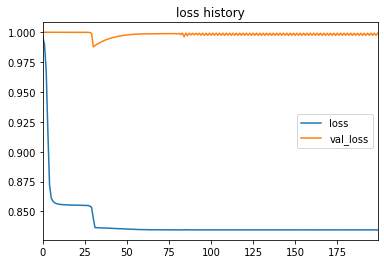

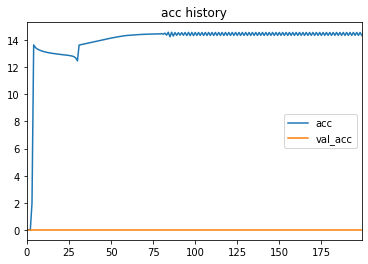

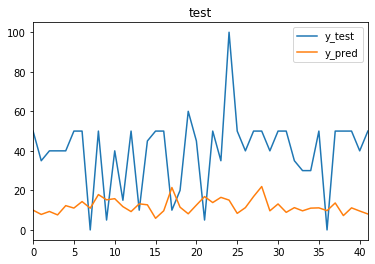

In [14]:
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, ActivityRegularization


drop_rate = 0.015
model = Sequential()
model.add(Dense(10240, activation='relu', input_shape=(xTrain.shape[1],)))
#model.add(Dropout(rate=drop_rate))
#model.add(Dropout(rate=drop_rate))
model.add(Dense(1024, activation='relu'))
#model.add(Dropout(rate=drop_rate))
model.add(Dense(100, activation='relu'))
#model.add(Dropout(rate=drop_rate))
model.add(Dense(1, activation='linear'))
model.compile(loss=loss_tf,
              optimizer=RMSprop(lr=0.0001),
              metrics=[gain_tf])

history = model.fit(xTrain, yTrain, epochs=200, verbose=1, batch_size=512, validation_split=0.20)

loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot(title="loss history")

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot(title="acc history")

yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = model.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), model.predict(xTrain).ravel()))
print("train gain_ratio: ", avg_gain_ratio(yTrain.ravel(), model.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [15]:
# from core.models import AcceptanceModel
# from core.utils.data_augmentation import DASampling


# drop_rate = 0.15
# model = Sequential()
# model.add(Dense(2000, activation='relu', input_shape=(11,)))
# #model.add(Dropout(rate=drop_rate))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# #model.add(Dropout(rate=drop_rate))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss="mse",
#               optimizer='rmsprop',#optimizer=RMSprop(lr=0.0001),
#               metrics=[gain_tf])
# amodel = AcceptanceModel(model)
# axTrain, ayTrain = DASampling().generate_data(xTrain, yTrain, 10000)
# amodel.fit(
#     axTrain,
#     ayTrain,
#     fit_kwargs={
#         "epochs": 16,
#         "batch_size": 10240,
#         "validation_split": 0.2,
#         "verbose": 1
#     }
# )
# # amodel.fit(
# #     xTrain,
# #     yTrain,
# #     fit_kwargs={
# #         "epochs": 8,
# #         "batch_size": 10000,
# #         #"validation_split": 0.2,
# #         "verbose":1
# #     }
# # )

# yPred = amodel.predict(xTest, predict_kwargs={"batch_size": 10000})

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
# out_data.plot(title="test")

# yPred = amodel.predict(xTest)
# print("train gain: ", gain_mean(yTrain.ravel(), amodel.predict(xTrain).ravel()))
# print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), amodel.predict(xTrain).ravel()))

# print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
# print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [16]:
axTrain, ayTrain = DASampling().generate_data(xTrain, yTrain, 1000)
aamodel = AcceptanceModel.get_trained_model(xTrain=axTrain, yTrain=ayTrain)

yPred = aamodel.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = aamodel.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), aamodel.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), aamodel.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))


NameError: name 'DASampling' is not defined

In [ ]:
aamodel.fit(xTrain, yTrain)
yPred = aamodel.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = aamodel.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), aamodel.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), aamodel.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [ ]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

model = RandomForestClassifier(
    n_estimators=256,
    criterion="entropy",
    #min_samples_split=3,
    #bootstrap_features=True,
    n_jobs=8
)
model = MLPClassifier(
    #hidden_layer_sizes=(1024, 1024,),
    #hidden_layer_sizes=(256, 256, 256, ),
    hidden_layer_sizes=(1024, ),
    solver='sgd',
    max_iter=512,
    batch_size=xTrain.shape[1],
    learning_rate='adaptive',
#     early_stopping=True,
#     n_iter_no_change=128
)
model.fit(xTrain, yTrain.ravel())

yPred = model.predict(xTest)

print("train gain: ", gain_mean(yTrain.ravel(), model.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), model.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': ['auto', 512],
    'learning_rate_init': [0.001, 0.0001, 0.00001]
}

model = MLPClassifier(
    #hidden_layer_sizes=(1024, 1024,),
    #hidden_layer_sizes=(256, 256, 256, ),
    hidden_layer_sizes=(1024,),
    solver='sgd',
    max_iter=128,
    batch_size=xTrain.shape[1],
    learning_rate='adaptive',
#     early_stopping=True,
#     n_iter_no_change=128
)
clf = GridSearchCV(model, parameters, cv=3,)

clf.fit(xTrain, yTrain.ravel())

In [ ]:

yPred = clf.predict(xTest)

print("train gain: ", gain_mean(yTrain.ravel(), clf.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), clf.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

m_pca = PCA(n_components=2)
model = MLPClassifier(
    hidden_layer_sizes=(1024,),
    solver='sgd',
    max_iter=1024,
    batch_size=xTrain.shape[1],
    learning_rate='adaptive',
    activation='relu',
)
p = Pipeline([('pca', m_pca), ('mlp', model)])
p.fit(xTrain, yTrain.ravel())
yPred = p.predict(xTest)

print("train gain: ", gain_mean(yTrain.ravel(), p.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), p.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))